In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker


from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Adatok Transzformálása (Ár)

In [ ]:
def parse_price(price_str):
    """
    Átalakítja az ár stringet (pl. "62,03 M Ft", "1.06 Mrd Ft")
    numerikus értékké millió Forintban.
    """
    if pd.isna(price_str):
        return np.nan

    try:
        price_str = str(price_str).strip()

        value = np.nan

        if 'Mrd Ft' in price_str:
            # Milliárd Ft - konvertálás millió Ft-ba (*1000)
            num_str = price_str.replace(' Mrd Ft', '').replace(',', '.')
            value = float(num_str) * 1000
        elif 'M Ft' in price_str:
            # Millió Ft
            num_str = price_str.replace(' M Ft', '').replace(',', '.')
            value = float(num_str)
        else:
             num_str = price_str.replace(',', '.')
             value = float(num_str)

        return value

    except ValueError:
        print(f"Figyelmeztetés: Nem sikerült értelmezni az árat: '{price_str}'")
        return np.nan

Adatbeolvasás és Elsődleges Tisztítás

In [ ]:
df = pd.read_csv('data_geocoded_partial.csv')

print("Adathalmaz mérete:", df.shape)
print("\nElső 5 sor:")
print(df.head())
print("\nOszlopok típusai:")
print(df.info())

df['price_m_ft_cleaned'] = df['price'].apply(parse_price)

print("\nTisztított ár és eredeti ár (millió Ft) összehasonlítása:")
print(df[['price', 'price_cleaned', 'price_mill_ft']].head())

df.rename(columns={'price_mill_ft': 'price_m_ft'}, inplace=True)

# --- Hiányzó értékek ellenőrzése ---
print("\nHiányzó értékek oszloponként:")
print(df.isnull().sum())
df.dropna(inplace=True)

Adathalmaz mérete: (20363, 25)

Első 5 sor:
   listing_id        price                                 address  sqm  \
0    34543265   62,03 M Ft  Budapest XI. kerület, Szerenád utca 2.   30   
1    34591876  186,41 M Ft      Budapest XI. kerület, Bodorka utca   98   
2    34591847  149,45 M Ft      Budapest XI. kerület, Bodorka utca   71   
3    34437899  145,90 M Ft      Budapest XIII. kerület, Csele utca   84   
4    34367201  102,20 M Ft  Budapest XIII. kerület, Diós utca 6-8.   69   

   rooms  tegla_epitesu  panel  csuszozsalus  uj_epitesu  ujszeru  ...  \
0      1           True  False         False        True    False  ...   
1      4           True  False         False        True    False  ...   
2      3           True  False         False        True    False  ...   
3      4           True  False         False        True    False  ...   
4      3           True  False         False        True    False  ...   

   epitve_1950_1980  epitve_2001_2010  epitve_2011_utan  udv

Adatok Transzformálása (Ár)

Exploratív Adatanalízis (EDA) és Vizualizáció
Ismerjük meg az adatokat vizuálisan, most már a tisztított árral dolgozva.

A 99. percentilis: 514.14 Millió Ft

Numerikus oszlopok leíró statisztikái (frissítve):
       price_m_ft_cleaned           sqm         rooms      latitude  \
count        20159.000000  20159.000000  20159.000000  18190.000000   
mean           120.234921     77.171040      2.680788     47.504867   
std             76.511242     40.386614      1.219953      0.037601   
min              7.000000      9.000000      1.000000     46.272376   
25%             72.500000     52.000000      2.000000     47.488176   
50%             98.200000     70.000000      3.000000     47.504543   
75%            140.000000     93.000000      3.000000     47.523483   
max            513.000000   1240.000000     21.000000     47.771652   

          longitude  
count  18190.000000  
mean      19.070335  
std        0.044914  
min       18.937263  
25%       19.050380  
50%       19.066476  
75%       19.088738  
max       20.160432  

Numerikus oszlopok leíró statisztikái (frissítve):
       price_m_ft_clea

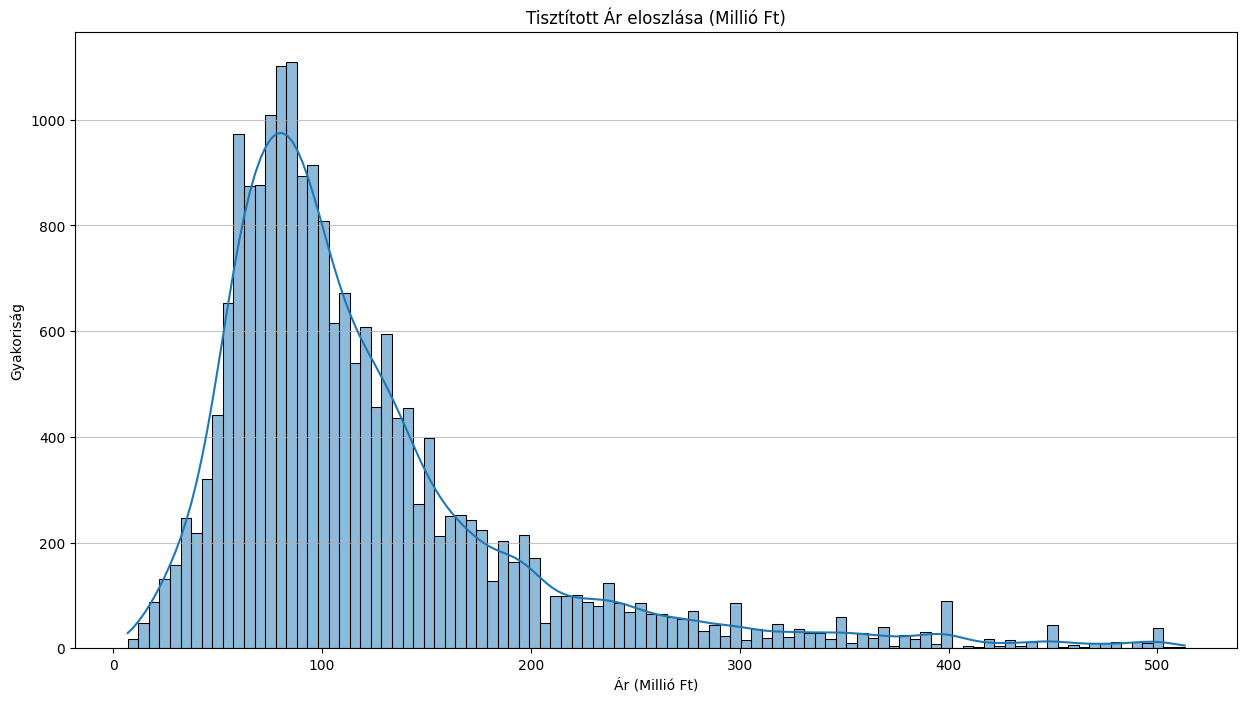

In [ ]:
q99 = df['price_m_ft_cleaned'].dropna().quantile(0.99)
print(f"A 99. percentilis: {q99:.2f} Millió Ft")
df_filtered_for_plot = df[df['price_m_ft_cleaned'] <= q99]

print("\nNumerikus oszlopok leíró statisztikái (frissítve):")
numeric_cols_for_describe = ['price_m_ft_cleaned', 'sqm', 'rooms', 'latitude', 'longitude']
print(df_filtered_for_plot[numeric_cols_for_describe].describe())

print("\nNumerikus oszlopok leíró statisztikái (frissítve):")
numeric_cols_for_describe = ['price_m_ft_cleaned', 'sqm', 'rooms']
print(df[numeric_cols_for_describe].describe())

plt.figure(figsize=(15, 8))
sns.histplot(df_filtered_for_plot['price_m_ft_cleaned'].dropna(), kde=True, bins=100)
plt.title('Tisztított Ár eloszlása (Millió Ft)')
plt.xlabel('Ár (Millió Ft)')
plt.ylabel('Gyakoriság')
plt.grid(axis='y', alpha=0.75)
plt.show()

A 99. percentilis: 226.00 négyzetméter.


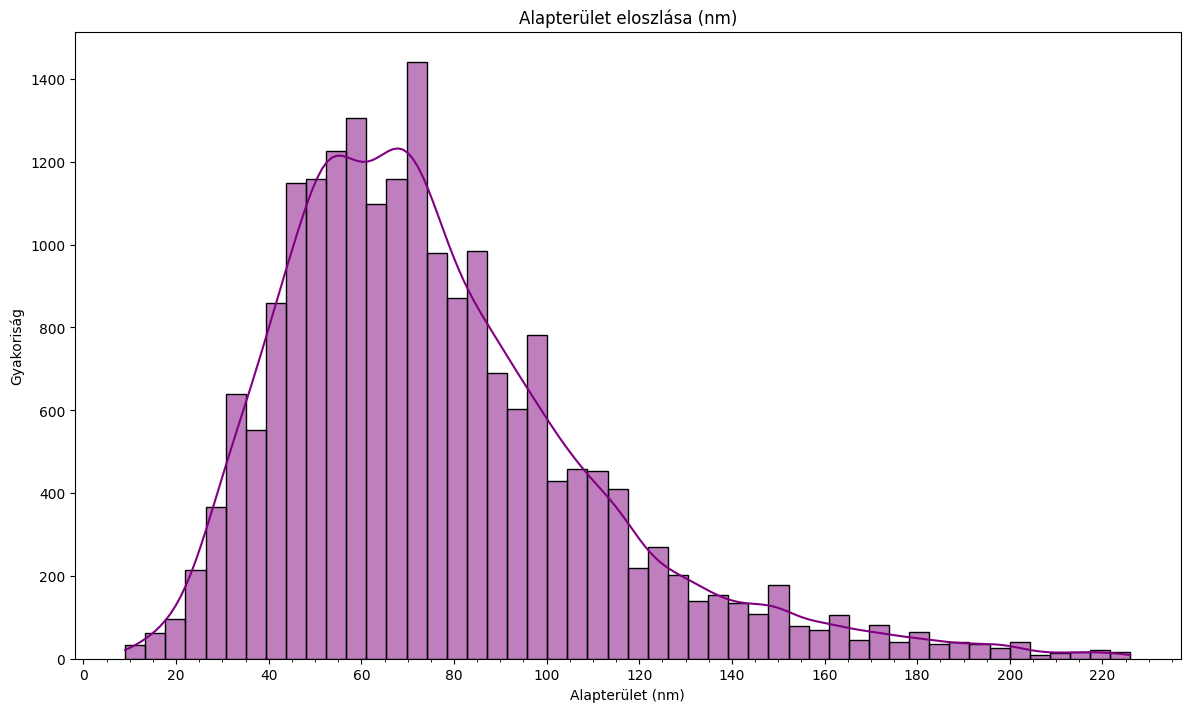

In [ ]:
q99 = df['sqm'].dropna().quantile(0.99)
print(f"A 99. percentilis: {q99:.2f} négyzetméter.")
df_filtered_for_plot = df[df['sqm'] <= q99]

plt.figure(figsize=(12, 7))
ax = sns.histplot(df_filtered_for_plot['sqm'].dropna(), kde=True, bins=50, color='purple')

x_major_step  = 20
x_major_locator = mticker.MultipleLocator(base=x_major_step)
ax.xaxis.set_major_locator(x_major_locator)
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(n=4))
plt.tight_layout()

plt.title('Alapterület eloszlása (nm)')
plt.xlabel('Alapterület (nm)')
plt.ylabel('Gyakoriság')
plt.show()

A 99. percentilis: 6.00 szoba.


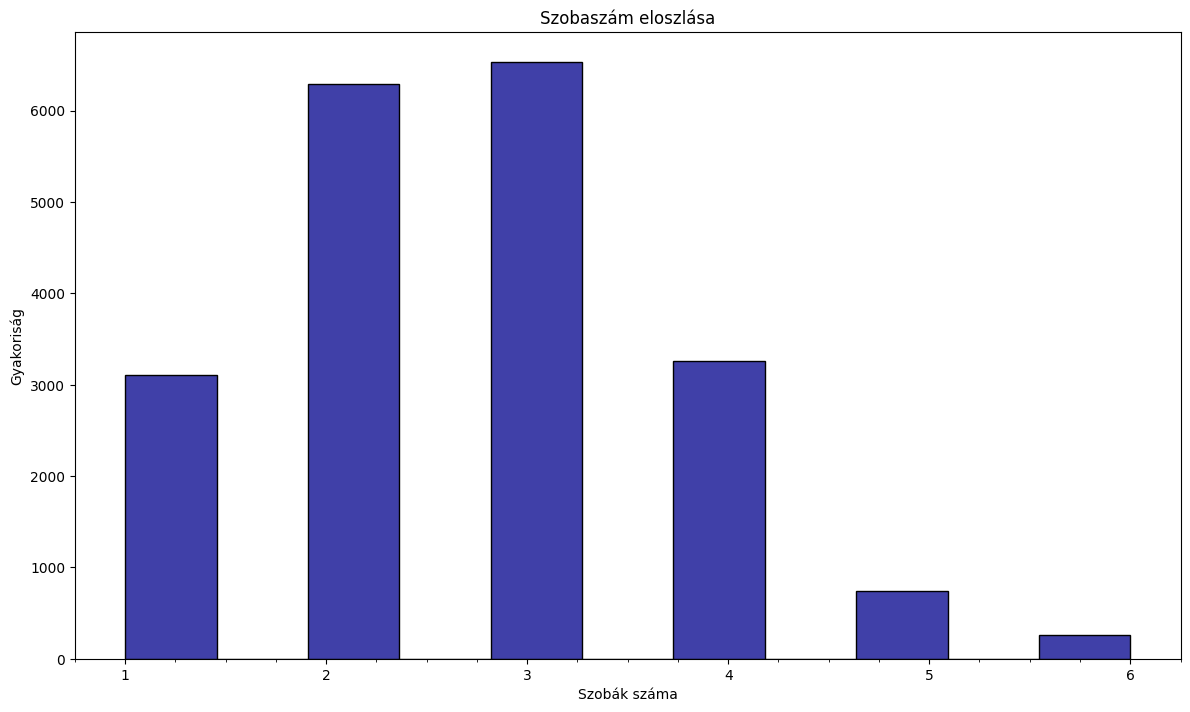

In [ ]:
# Szobák eloszlása
q99 = df['rooms'].dropna().quantile(0.99)
print(f"A 99. percentilis: {q99:.2f} szoba.")
df_filtered_for_plot = df[df['rooms'] <= q99]

plt.figure(figsize=(12, 7))
ax = sns.histplot(df_filtered_for_plot['rooms'].dropna(), bins=11, color='darkblue') # .dropna() itt is fontos lehet

x_major_step  = 1
x_major_locator = mticker.MultipleLocator(base=x_major_step)
ax.xaxis.set_major_locator(x_major_locator)
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(n=4))
plt.tight_layout()

plt.title('Szobaszám eloszlása')
plt.xlabel('Szobák száma')
plt.ylabel('Gyakoriság')
plt.show()


Logikai oszlopok:
Index(['tegla_epitesu', 'panel', 'csuszozsalus', 'uj_epitesu', 'ujszeru',
       'felujitott', 'jo_allapotu', 'kozepes_allapotu', 'felujitando',
       'epitve_1950_elott', 'epitve_1950_1980', 'epitve_2001_2010',
       'epitve_2011_utan', 'udvari_beallo', 'teremgarazs', 'onallo_garazs',
       'utcan_parkolas'],
      dtype='object')


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


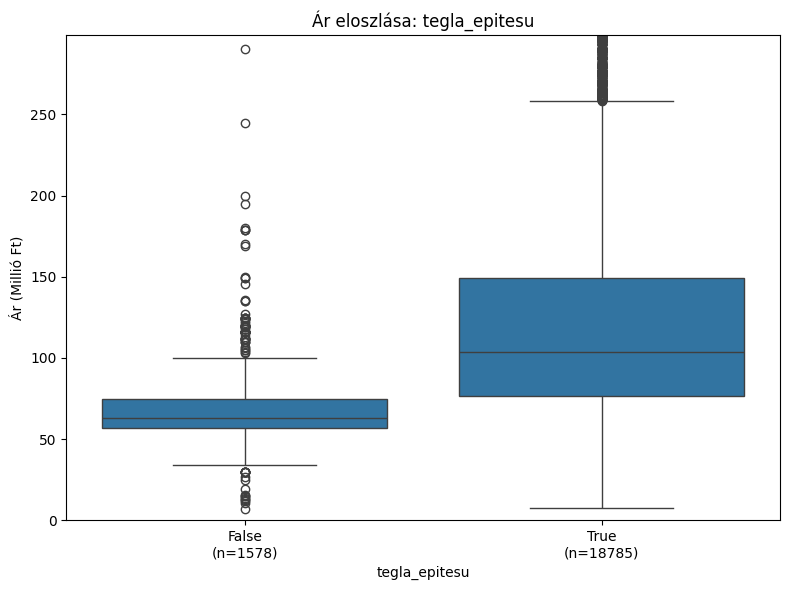

Elemszámok - tegla_epitesu: False=1578, True=18785


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


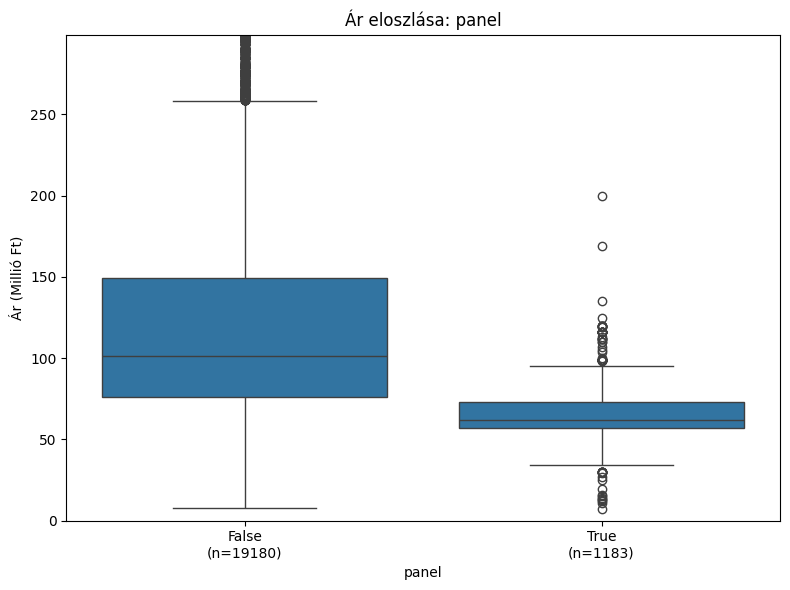

Elemszámok - panel: False=19180, True=1183


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


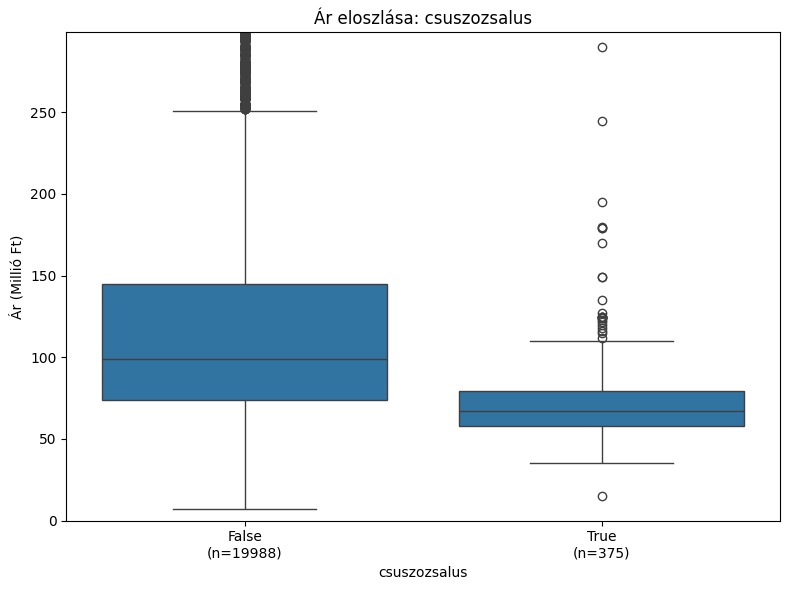

Elemszámok - csuszozsalus: False=19988, True=375


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


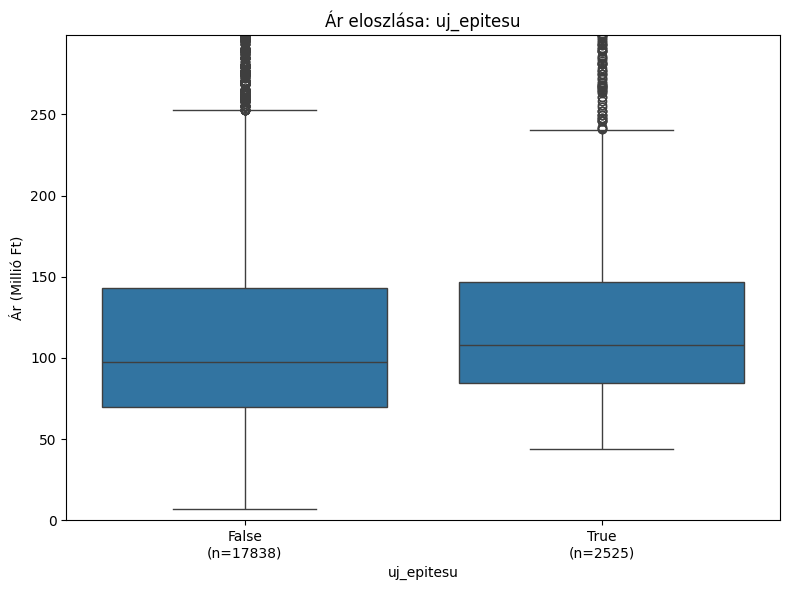

<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


Elemszámok - uj_epitesu: False=17838, True=2525


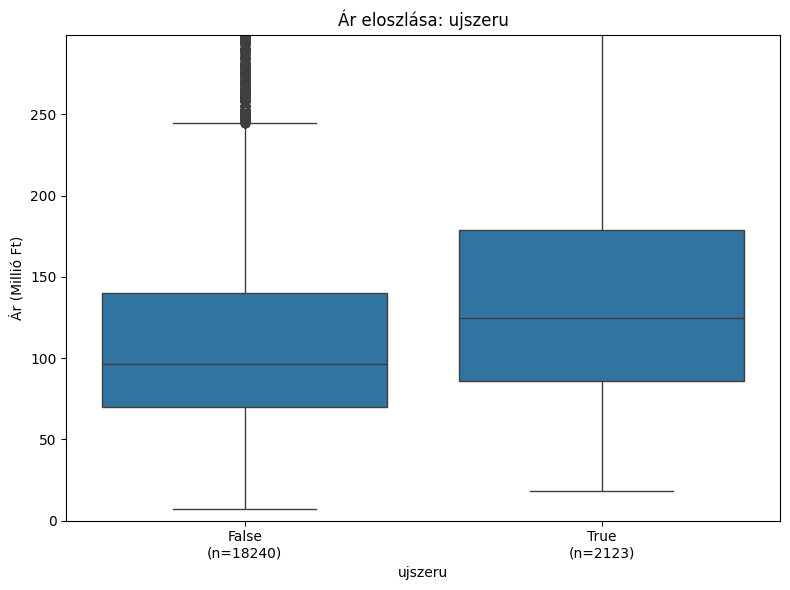

Elemszámok - ujszeru: False=18240, True=2123


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


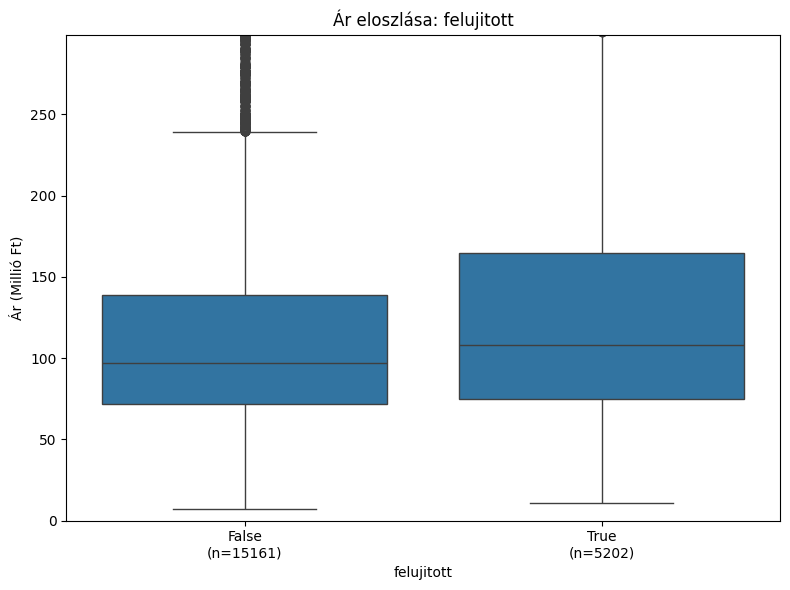

Elemszámok - felujitott: False=15161, True=5202


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


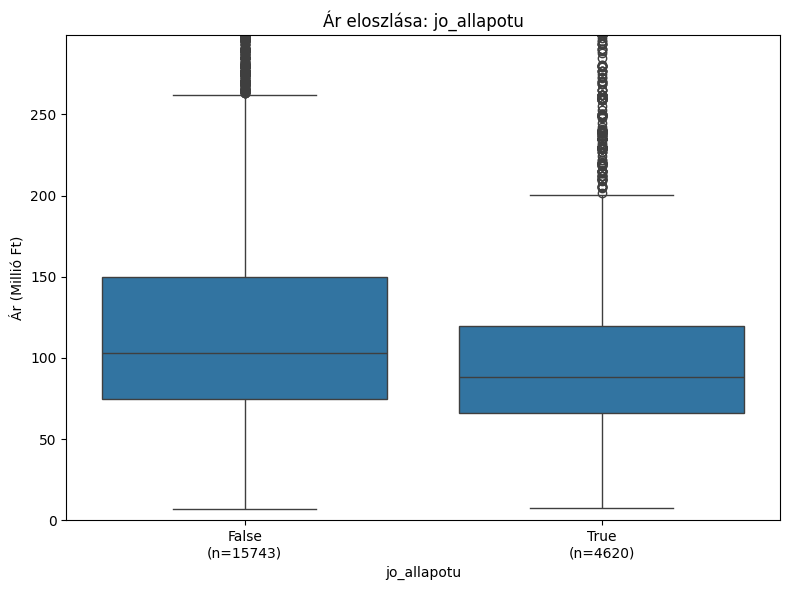

Elemszámok - jo_allapotu: False=15743, True=4620


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


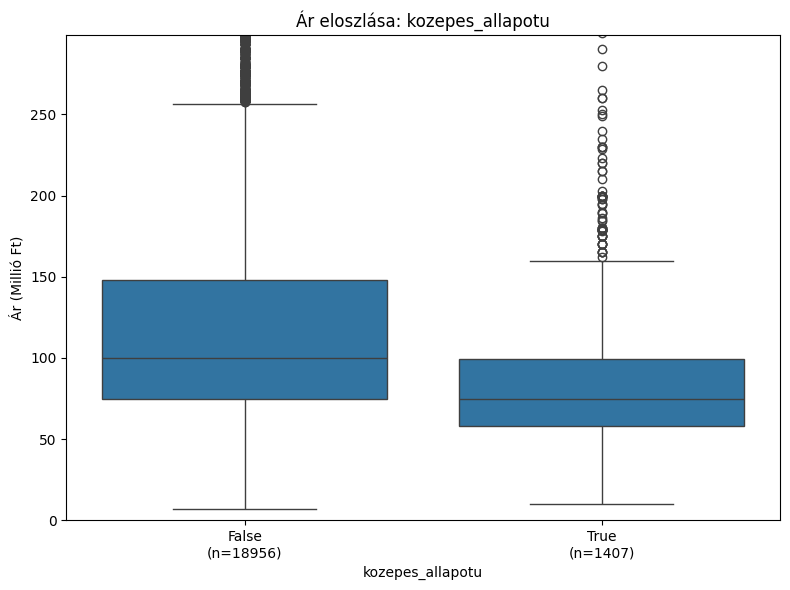

<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


Elemszámok - kozepes_allapotu: False=18956, True=1407


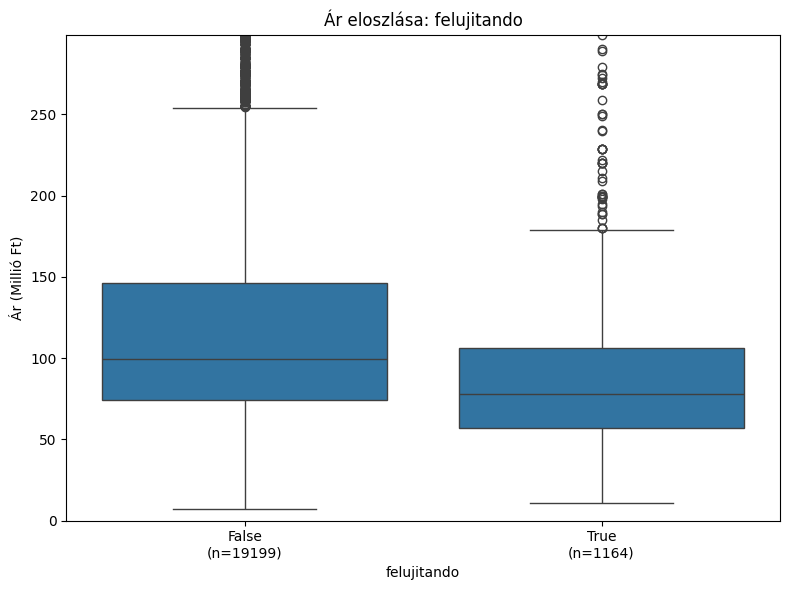

Elemszámok - felujitando: False=19199, True=1164


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


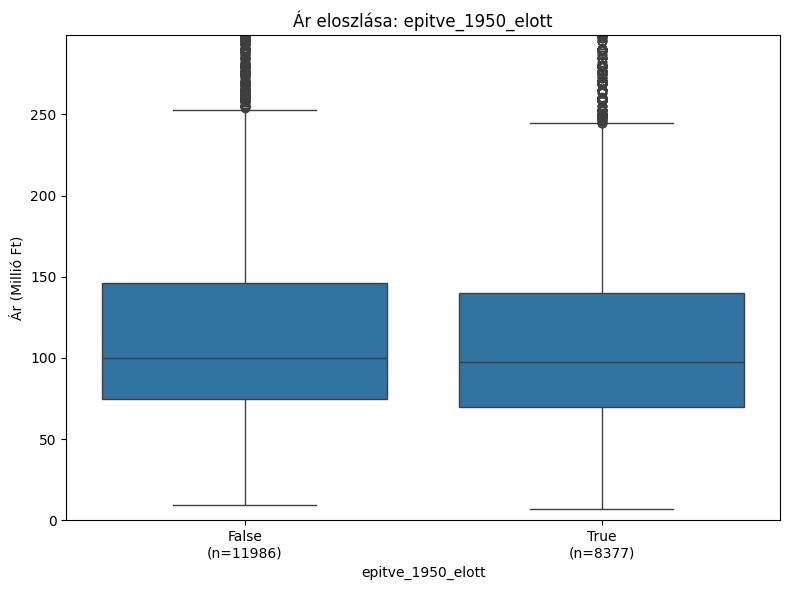

Elemszámok - epitve_1950_elott: False=11986, True=8377


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


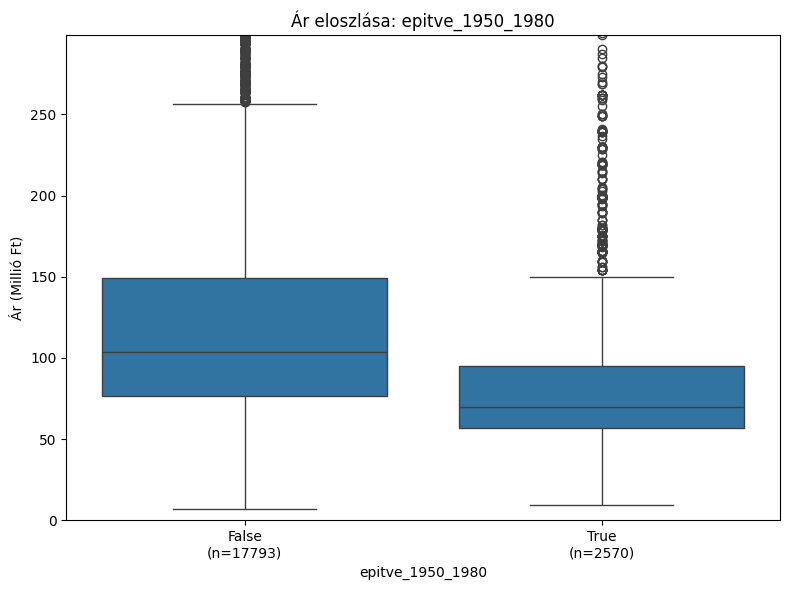

Elemszámok - epitve_1950_1980: False=17793, True=2570


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


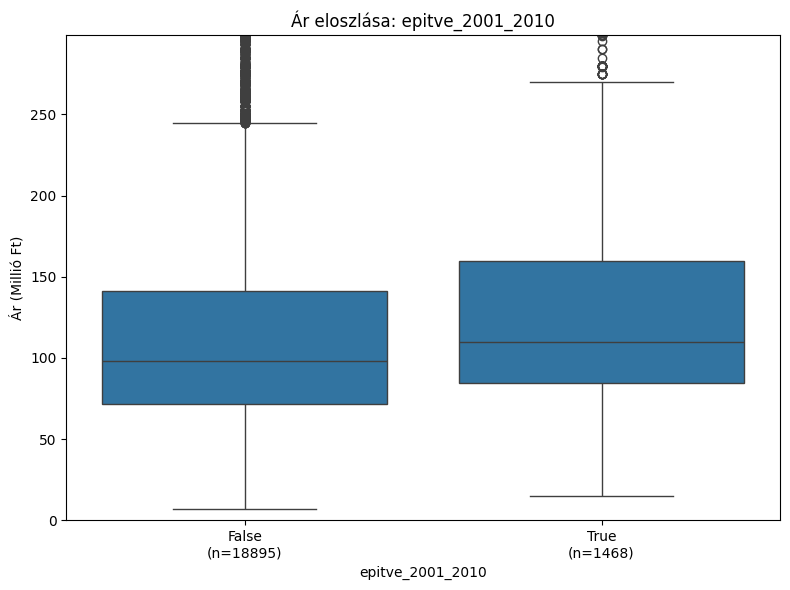

Elemszámok - epitve_2001_2010: False=18895, True=1468


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


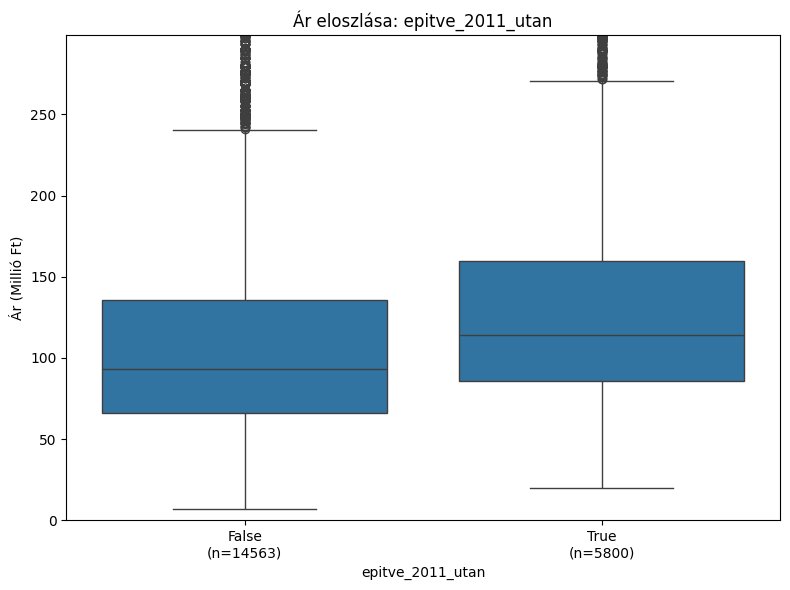

Elemszámok - epitve_2011_utan: False=14563, True=5800


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


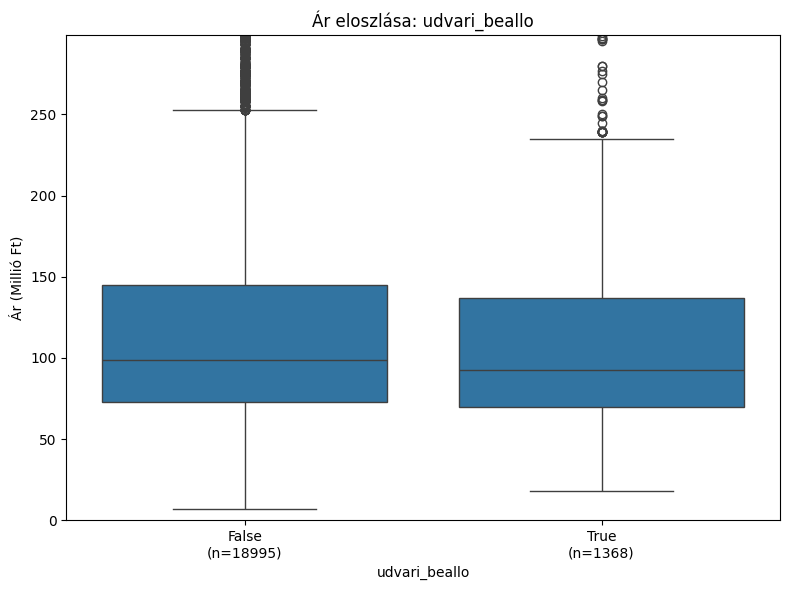

Elemszámok - udvari_beallo: False=18995, True=1368


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


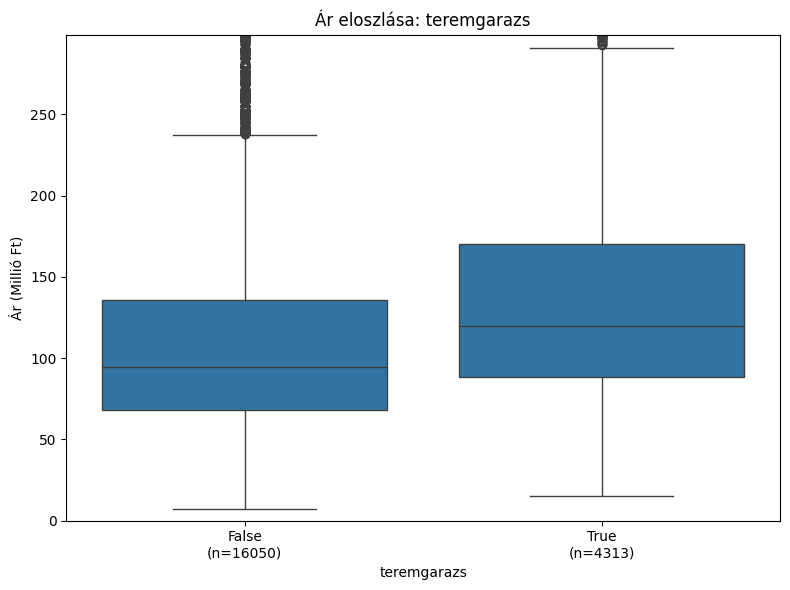

Elemszámok - teremgarazs: False=16050, True=4313


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


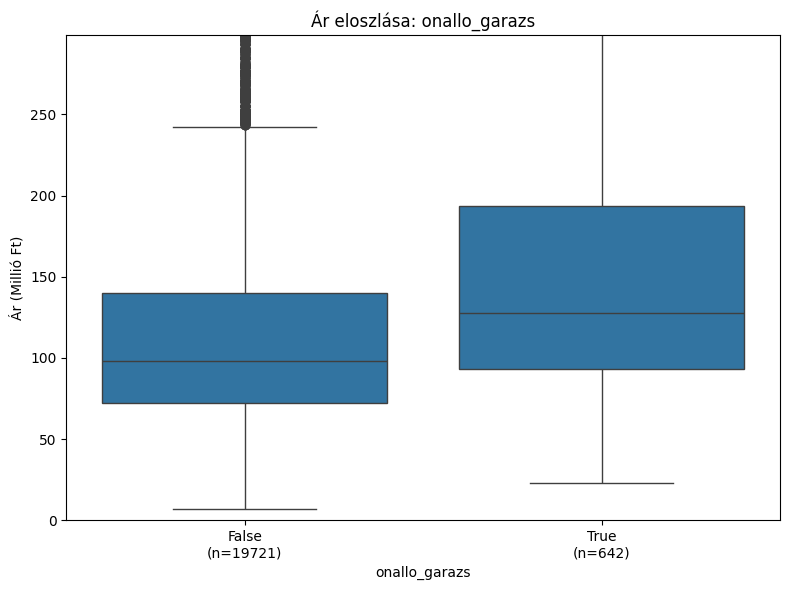

Elemszámok - onallo_garazs: False=19721, True=642


<ipython-input-47-49822f97e174>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


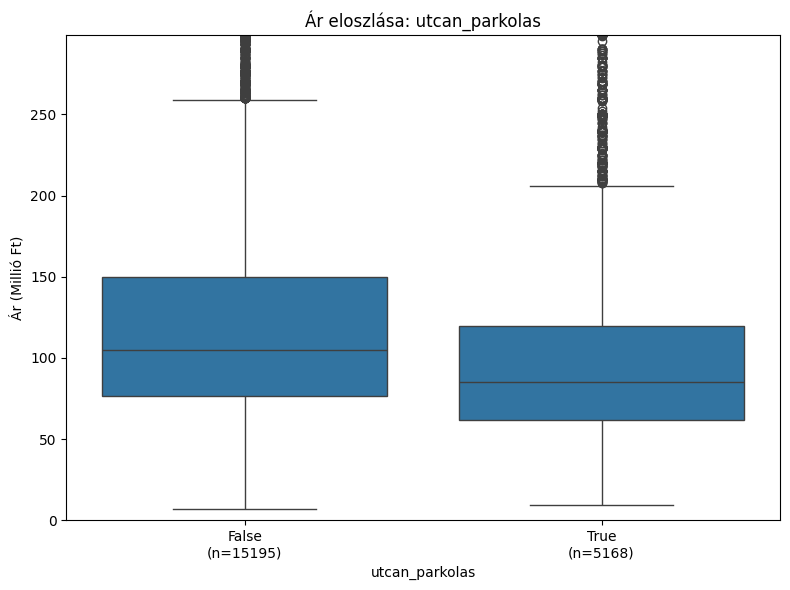

Elemszámok - utcan_parkolas: False=15195, True=5168


In [ ]:
# --- Kategorikus (logikai) oszlopok vizsgálata ---
boolean_cols = df.select_dtypes(include='bool').columns
print("\nLogikai oszlopok:")
print(boolean_cols)

# cols_to_plot = ['tegla_epitesu', 'panel', 'csuszozsalus', 'uj_epitesu', 'ujszeru',
#                 'felujitott', 'jo_allapotu', 'kozepes_allapotu', 'felujitando',
#                 'epitve_1950_elott', 'epitve_1950_1980', 'epitve_2001_2010',
#                 'epitve_2011_utan', 'udvari_beallo', 'teremgarazs', 'onallo_garazs',
#                 'utcan_parkolas']

for col in boolean_cols:
    if col in df.columns:
        plt.figure(figsize=(8, 6))

        counts = df[col].dropna().value_counts()
        count_false = counts.get(False, 0)
        count_true = counts.get(True, 0)

        ax = sns.boxplot(x=col, y='price_m_ft_cleaned', data=df.dropna(subset=[col, 'price_m_ft_cleaned'])) # Jobb, ha a NaN-okat explicit kezeljük

        plt.title(f'Ár eloszlása: {col}')
        plt.xlabel(col)
        plt.ylabel('Ár (Millió Ft)')

        price_quantile_95 = df.dropna(subset=[col, 'price_m_ft_cleaned'])['price_m_ft_cleaned'].quantile(0.95)
        plt.ylim(0, price_quantile_95)

        new_labels = [f"False\n(n={count_false})", f"True\n(n={count_true})"]
        ax.set_xticklabels(new_labels)

        plt.tight_layout() # Igazítás
        plt.show()

        print(f"Elemszámok - {col}: False={count_false}, True={count_true}")

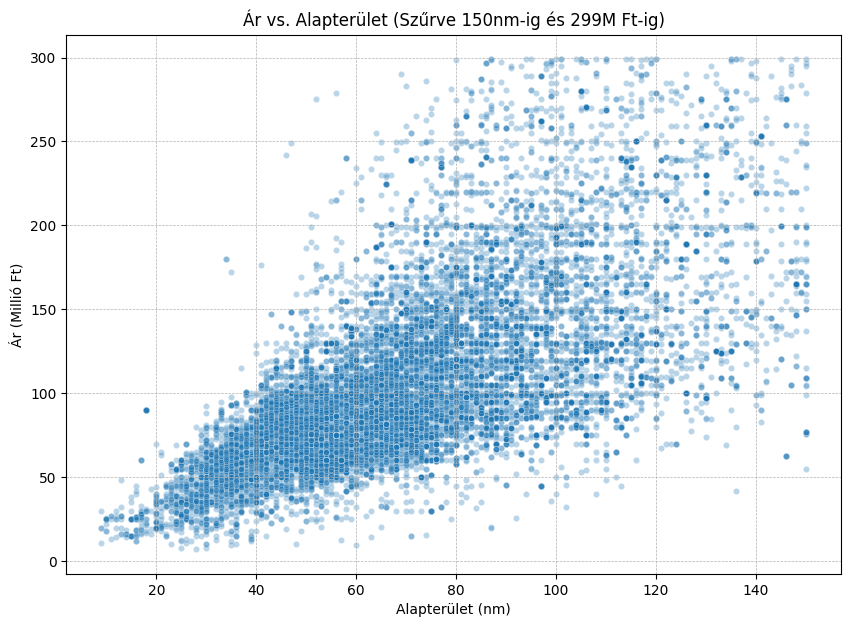


Eredeti adatsor mérete: 20363
Szűrt adatsor mérete: 18834


In [ ]:
sqm_q95 = df['sqm'].dropna().quantile(0.95)
price_qsqm_q95 = df['price_m_ft_cleaned'].dropna().quantile(0.95)

df_filtered_scatter = df[(df['sqm'] <= sqm_q95) & (df['price_m_ft_cleaned'] <= price_qsqm_q95)].copy()

plt.figure(figsize=(10, 7))
sns.scatterplot(x='sqm', y='price_m_ft_cleaned', data=df_filtered_scatter, alpha=0.3, s=20)
plt.title(f'Ár vs. Alapterület (Szűrve {sqm_q95:.0f}nm-ig és {price_qsqm_q95:.0f}M Ft-ig)')
plt.xlabel('Alapterület (nm)')
plt.ylabel('Ár (Millió Ft)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

print(f"\nEredeti adatsor mérete: {len(df)}")
print(f"Szűrt adatsor mérete: {len(df_filtered_scatter)}")

Szűrési küszöbök: Alapterület <= 150.00 nm, Ár <= 299.00 Millió Ft


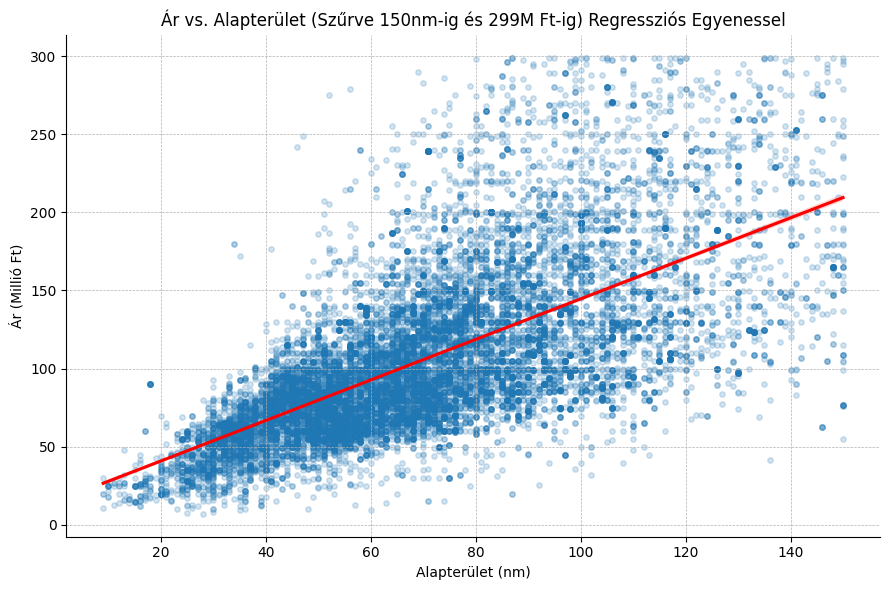

In [ ]:
sqm_q95 = df['sqm'].dropna().quantile(0.95)
price_q95 = df['price_m_ft_cleaned'].dropna().quantile(0.95)
print(f"Szűrési küszöbök: Alapterület <= {sqm_q95:.2f} nm, Ár <= {price_q95:.2f} Millió Ft")

df_filtered_scatter = df[(df['sqm'] <= sqm_q95) & (df['price_m_ft_cleaned'] <= price_q95)].copy()

lm = sns.lmplot(
    x='sqm',
    y='price_m_ft_cleaned',
    data=df_filtered_scatter,
    height=6,
    aspect=1.5,
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.2, 's': 15}
)


plt.title(f'Ár vs. Alapterület (Szűrve {sqm_q95:.0f}nm-ig és {price_q95:.0f}M Ft-ig) Regressziós Egyenessel')
plt.xlabel('Alapterület (nm)')
plt.ylabel('Ár (Millió Ft)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Rácsozás

plt.tight_layout() # Igazítás
plt.show()

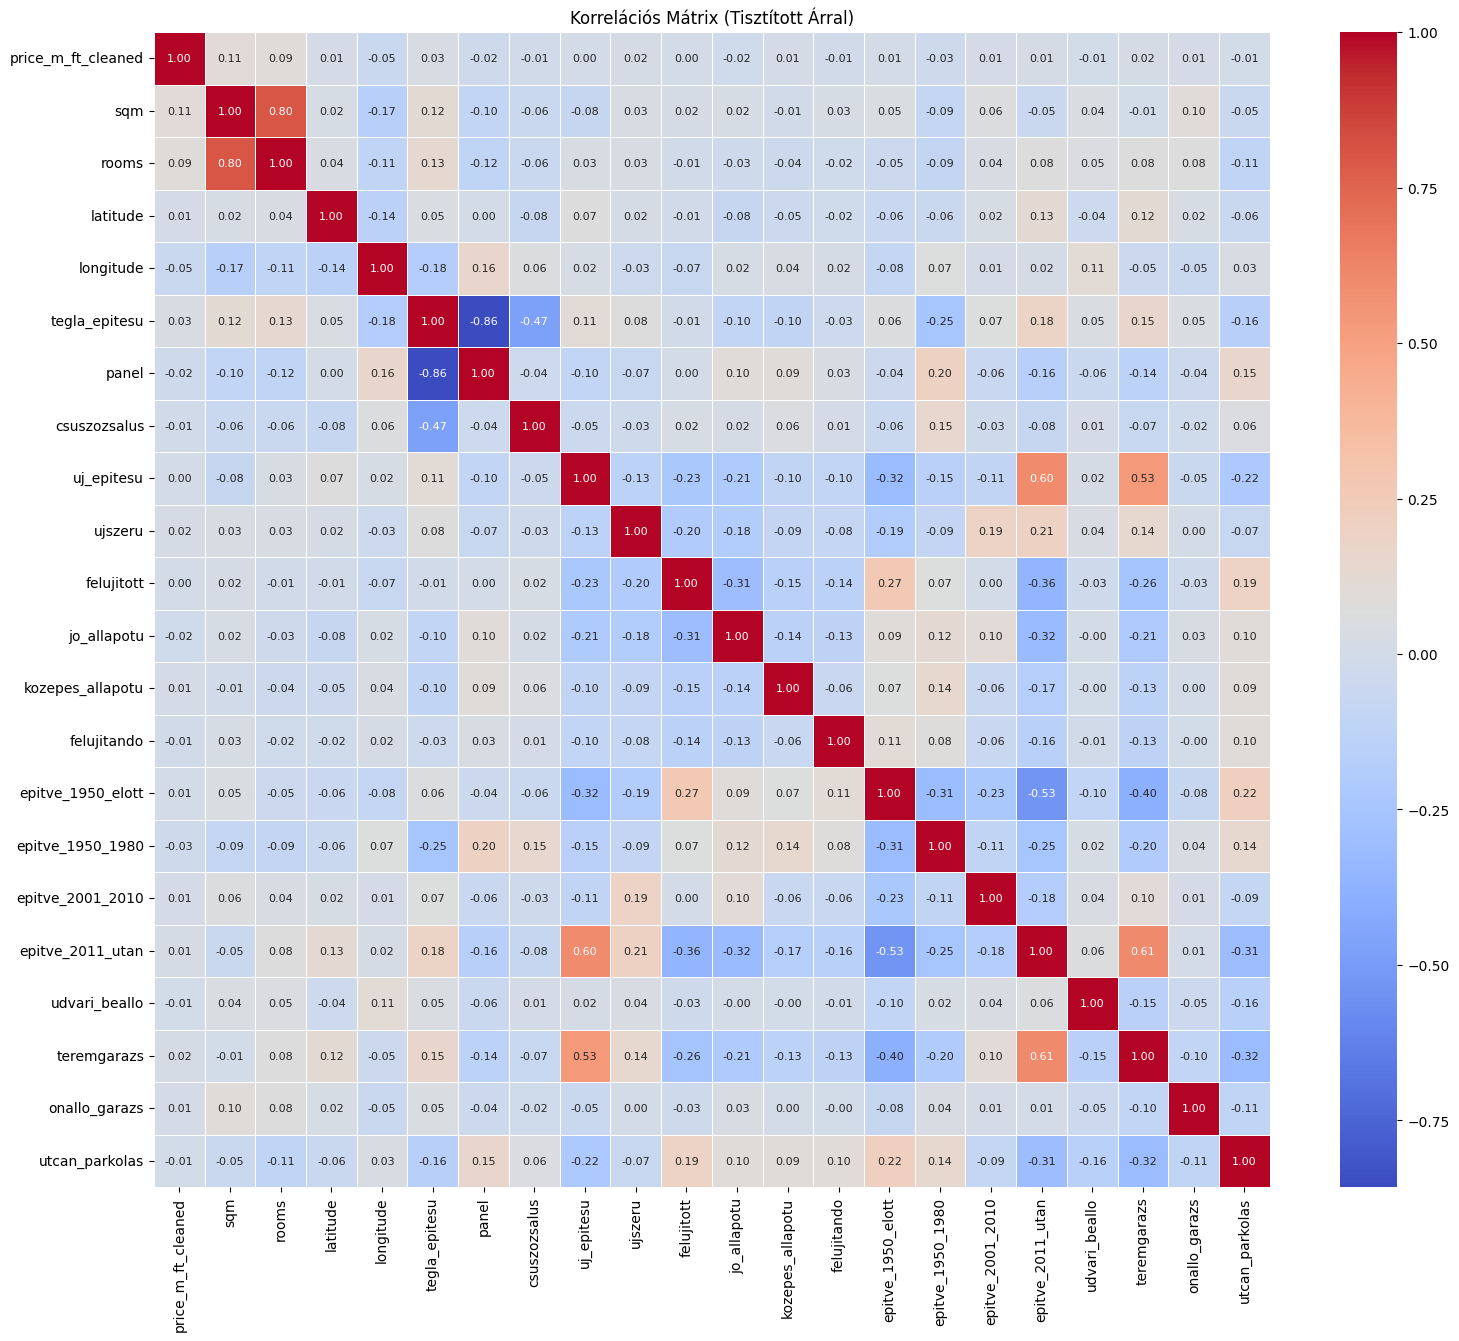

In [ ]:
# --- Korrelációs Mátrix ---
cols_for_corr = ['price_m_ft_cleaned', 'sqm', 'rooms', 'latitude', 'longitude'] + list(boolean_cols)
cols_for_corr = [col for col in cols_for_corr if col in df.columns]

corr_df = df[cols_for_corr].copy()

for col in corr_df.select_dtypes(include='bool').columns:
    corr_df[col] = corr_df[col].astype(int)

corr_df.dropna(inplace=True)

plt.figure(figsize=(18, 15))
correlation_matrix = corr_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Korrelációs Mátrix (Tisztított Árral)')
plt.show()

In [ ]:
print(df.info())


Oszlopok típusai (konverzió után):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20363 entries, 0 to 20362
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          20363 non-null  int64  
 1   price               20363 non-null  object 
 2   address             20363 non-null  object 
 3   sqm                 20363 non-null  int64  
 4   rooms               20363 non-null  int64  
 5   tegla_epitesu       20363 non-null  bool   
 6   panel               20363 non-null  bool   
 7   csuszozsalus        20363 non-null  bool   
 8   uj_epitesu          20363 non-null  bool   
 9   ujszeru             20363 non-null  bool   
 10  felujitott          20363 non-null  bool   
 11  jo_allapotu         20363 non-null  bool   
 12  kozepes_allapotu    20363 non-null  bool   
 13  felujitando         20363 non-null  bool   
 14  epitve_1950_elott   20363 non-null  bool   
 15  epitve_1950_1980 

In [ ]:
df['price_per_sqm'] = np.where(df['sqm'] > 0,
                               df['price_m_ft_cleaned'] * 1000000 / df['sqm'],
                               np.nan)
y_price = df['price_m_ft_cleaned'].copy()
y_price_per_sqm = df['price_per_sqm'].copy()

print("\nCélváltozók létrehozva.")
print("Hiányzó értékek y_price-ban:", y_price.isnull().sum())
print("Hiányzó értékek y_price_per_sqm-ben:", y_price_per_sqm.isnull().sum())


Célváltozók létrehozva.
Hiányzó értékek y_price-ban: 0
Hiányzó értékek y_price_per_sqm-ben: 0


In [ ]:
potential_bools = ['tegla_epitesu','panel','csuszozsalus','uj_epitesu','ujszeru',
                   'felujitott','jo_allapotu','kozepes_allapotu','felujitando',
                   'epitve_1950_elott','epitve_1950_1980','epitve_2001_2010',
                   'epitve_2011_utan','udvari_beallo','teremgarazs','onallo_garazs',
                   'utcan_parkolas']

boolean_cols_list = [col for col in potential_bools if col in df.columns and df[col].dtype == 'bool']
numeric_features = ['sqm', 'rooms', 'latitude', 'longitude']
features_list = numeric_features + boolean_cols_list

X = df[features_list].copy()

for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

print("\nJellemző mátrix (X) létrehozva.")
print(f"X mérete: {X.shape}")
print(f"Használt jellemzők: {features_list}")

# --- Hiányzó értékek kezelése X-ben és a célváltozókban ---
print(f"\nHiányzó értékek X-ben kezdetben: {X.isnull().sum().sum()}")
print(f"Hiányzó értékek y_price-ban kezdetben: {y_price.isnull().sum()}")
print(f"Hiányzó értékek y_price_per_sqm-ben kezdetben: {y_price_per_sqm.isnull().sum()}")

X.dropna(inplace=True)

y_price = y_price[X.index]
y_price_per_sqm = y_price_per_sqm[X.index]

y_price.dropna(inplace=True)
y_price_per_sqm.dropna(inplace=True)

X_for_price = X.loc[y_price.index]
X_for_price_per_sqm = X.loc[y_price_per_sqm.index]


print(f"\nAdatok mérete (ár modellezéséhez): X={X_for_price.shape}, y={y_price.shape}")
print(f"Adatok mérete (nm ár modellezéséhez): X={X_for_price_per_sqm.shape}, y={y_price_per_sqm.shape}")

print(f"\nHiányzó értékek ellenőrzése törlés után:")
print(f"X (ár): {X_for_price.isnull().sum().sum()}, y_price: {y_price.isnull().sum()}")
print(f"X (nm ár): {X_for_price_per_sqm.isnull().sum().sum()}, y_price_per_sqm: {y_price_per_sqm.isnull().sum()}")


Jellemző mátrix (X) létrehozva.
X mérete: (20363, 21)
Használt jellemzők: ['sqm', 'rooms', 'latitude', 'longitude', 'tegla_epitesu', 'panel', 'csuszozsalus', 'uj_epitesu', 'ujszeru', 'felujitott', 'jo_allapotu', 'kozepes_allapotu', 'felujitando', 'epitve_1950_elott', 'epitve_1950_1980', 'epitve_2001_2010', 'epitve_2011_utan', 'udvari_beallo', 'teremgarazs', 'onallo_garazs', 'utcan_parkolas']

Hiányzó értékek X-ben kezdetben: 3952
Hiányzó értékek y_price-ban kezdetben: 0
Hiányzó értékek y_price_per_sqm-ben kezdetben: 0

Adatok mérete (ár modellezéséhez): X=(18387, 21), y=(18387,)
Adatok mérete (nm ár modellezéséhez): X=(18387, 21), y=(18387,)

Hiányzó értékek ellenőrzése törlés után:
X (ár): 0, y_price: 0
X (nm ár): 0, y_price_per_sqm: 0
